In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

%aimport manual_review_classifier

Populating the interactive namespace from numpy and matplotlib


In [2]:
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import os
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn import preprocessing
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle

from manual_review_classifier.ClassifierPlots import create_reliability_diagram
from manual_review_classifier.Analysis import determine_feature_importance

sns.set_style("white")
sns.set_context('notebook')

Using TensorFlow backend.


In [4]:
training_data = pd.read_pickle('../data/training_data.pkl')

In [5]:
training_data.groupby('call').size()

call
a    14589
f     1600
g     4309
s    21156
dtype: int64

In [6]:
# Get Labels
Y = pd.get_dummies(training_data.call).astype(float).values
# Get training data as numpy array
X = training_data.drop('call', axis=1).astype(float).values

In [7]:
X.shape

(41654, 71)

In [8]:
Y.shape

(41654, 4)

In [9]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [10]:
# define baseline model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(67, input_dim=71, kernel_initializer='normal', activation='relu'))
    model.add(Dense(23, activation='relu'))
    model.add(Dense(23, activation='relu'))
    model.add(Dense(4, kernel_initializer='normal', activation='sigmoid'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [11]:
estimator = KerasClassifier(build_fn=baseline_model, epochs=10, batch_size=5, verbose=1)

In [12]:
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)

In [13]:
if not os.path.exists('../data/deep_learning/multiclass_relu_probs.npy'):
    probabilities = cross_val_predict(estimator, X, Y, cv=kfold, method='predict_proba')
    np.save('../data/deep_learning/multiclass_relu_probs.npy', probabilities)
else:
    probabilities = np.load('../data/deep_learning/multiclass_relu_probs.npy')

In [14]:
predicted = np.array([list(a).index(max(list(a))) for a in list(probabilities)])

In [15]:
label_binarizer = preprocessing.LabelBinarizer()

label_binarizer.fit(range(max(predicted)+1))
predicted_transformed = label_binarizer.transform(predicted)

In [16]:
metrics.accuracy_score(Y, predicted_transformed)

0.80642915446295671

#### Classification report
* 0 = ambiguous
* 1 = fail
* 2 = germline
* 3 = somatic

In [17]:
print(metrics.classification_report(Y, predicted_transformed))

             precision    recall  f1-score   support

          0       0.80      0.74      0.77     14589
          1       0.56      0.47      0.51      1600
          2       0.70      0.73      0.71      4309
          3       0.85      0.89      0.87     21156

avg / total       0.80      0.81      0.80     41654



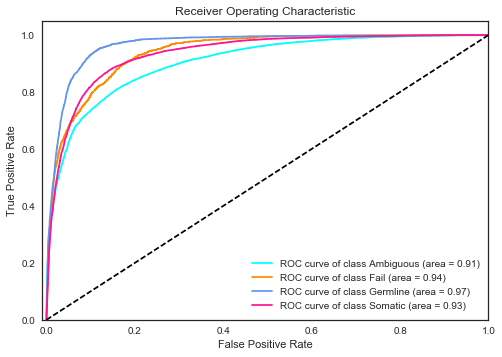

In [18]:
n_classes = Y.shape[1]
class_lookup = {0: 'Ambiguous', 1: 'Fail', 2: 'Germline', 3: 'Somatic'}
fpr = dict()
tpr = dict()
roc_auc = dict()
plt.title('Receiver Operating Characteristic')
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'deeppink'])
for i, color in zip(range(n_classes), colors):
    fpr[i], tpr[i], _ = metrics.roc_curve(Y[:, i], probabilities[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], color=color, label='ROC curve of class {0}'
             ' (area = {1:0.2f})'.format(class_lookup[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

confidence intervals +-:  [ 0.00040597  0.00343494  0.00447062  0.0064856   0.00769449  0.00790297
  0.00789482  0.00704294  0.0049625   0.00168334]


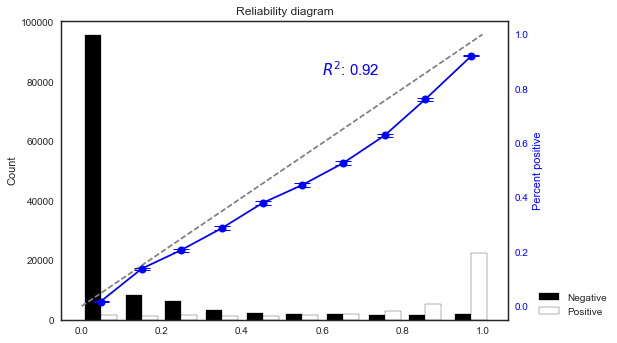

In [19]:
create_reliability_diagram(probabilities, Y, 
                           ['Ambiguous','Fail','Germline', 'Somatic'], 'blue')

## Feature importance analysis

In [20]:
feature_metrics = determine_feature_importance(baseline_model(), X, Y)

Epoch 1/10
41654/41654 [==============================] - 38s - loss: 0.6583 - acc: 0.7334    
Epoch 2/10
41654/41654 [==============================] - 39s - loss: 0.5449 - acc: 0.7886    
Epoch 3/10
41654/41654 [==============================] - 36s - loss: 0.5189 - acc: 0.7970    
Epoch 4/10
41654/41654 [==============================] - 36s - loss: 0.5059 - acc: 0.8030    
Epoch 5/10
41654/41654 [==============================] - 35s - loss: 0.4952 - acc: 0.8058    
Epoch 6/10
41654/41654 [==============================] - 35s - loss: 0.4887 - acc: 0.8076    
Epoch 7/10
41654/41654 [==============================] - 35s - loss: 0.4823 - acc: 0.8084    
Epoch 8/10
41654/41654 [==============================] - 35s - loss: 0.4783 - acc: 0.8109    
Epoch 9/10
41654/41654 [==============================] - 35s - loss: 0.4721 - acc: 0.8129    
Epoch 10/10
41654/41654 [==============================] - 7s     


In [21]:
feature_metrics.head(15)

,feature,shuffled_loss,shuffled_accuracy,delta_loss,delta_accuracy
0,disease,1.015848,0.627815,-0.535230,0.176718
1,reviewer,0.739476,0.697004,-0.258858,0.107529
31,tumor_VAF,0.702737,0.717386,-0.222119,0.087146
51,tumor_var_avg_mapping_quality,0.680393,0.723316,-0.199776,0.081217
48,tumor_var_avg_clipped_length,0.578110,0.758727,-0.097492,0.045806
54,tumor_var_avg_se_mapping_quality,0.534804,0.770970,-0.054186,0.033562
47,tumor_var_avg_basequality,0.603677,0.772843,-0.123059,0.031690
49,tumor_var_avg_distance_to_effective_3p_end,0.526829,0.781197,-0.046211,0.023335
55,tumor_var_avg_sum_mismatch_qualities,0.548038,0.781438,-0.067420,0.023095
2,normal_VAF,0.524731,0.791209,-0.044114,0.013324


## Refactor to single class classifier 
Manual reviewer's calling variants germline is problematic as the callers that produced the calls are designed to call somatic variants. These germline calls are likely very poor quality and in most analysis streams get thrown out anyway. While 'ambigous' variant exist in a grey area where the reviewer is unsure whether to call the variant somatic or fail. All of these classes (germile, ambiguous, and fail) are treated the same in downstream analysis (thrown out).

In [22]:
training_data.groupby('call').size()

call
a    14589
f     1600
g     4309
s    21156
dtype: int64

In [23]:
training_data['binary_call'] = training_data.call.replace(['a', 'f', 'g'], False)
training_data['binary_call'] = training_data['binary_call'].replace('s', True)

In [24]:
training_data.groupby('binary_call').size()

binary_call
False    20498
True     21156
dtype: int64

In [25]:
# Get Labels
binary_Y = training_data.binary_call.astype(int).values
# Get training data as numpy array
X = training_data.drop(['call', 'binary_call'], axis=1).astype(float).values

In [26]:
X.shape

(41654, 71)

In [27]:
binary_Y.shape

(41654,)

In [28]:
# define baseline model
def baseline_binary_model():
    # create model
    model = Sequential()
    model.add(Dense(67, input_dim=71, kernel_initializer='normal', activation='relu'))
    model.add(Dense(23, activation='relu'))
    model.add(Dense(23, activation='relu'))
    model.add(Dense(2, kernel_initializer='normal', activation='sigmoid'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [29]:
binary_estimator = KerasClassifier(build_fn=baseline_binary_model, epochs=10, batch_size=5, verbose=1)

In [30]:
binary_kfold = KFold(n_splits=10, shuffle=True, random_state=seed)

In [31]:
if not os.path.exists('../data/deep_learning/binary_relu_probs.npy'):
    binary_probabilities = cross_val_predict(binary_estimator, X, binary_Y, cv=binary_kfold, method='predict_proba')
    np.save('../data/deep_learning/binary_relu_probs.npy', binary_probabilities)
else:
    binary_probabilities = np.load('../data/deep_learning/binary_relu_probs.npy')

In [32]:
predicted = np.array([list(a).index(max(list(a))) for a in list(binary_probabilities)])

In [33]:
metrics.accuracy_score(binary_Y, predicted)

0.8684159984635329

In [34]:
print(metrics.classification_report(binary_Y, predicted))

             precision    recall  f1-score   support

          0       0.87      0.86      0.87     20498
          1       0.87      0.88      0.87     21156

avg / total       0.87      0.87      0.87     41654



In [35]:
somatic_prob = binary_probabilities[:,1]

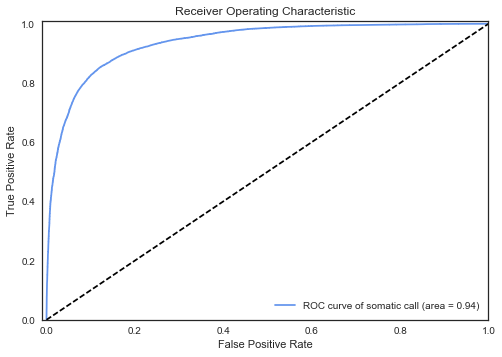

In [36]:
plt.title('Receiver Operating Characteristic')
fpr, tpr, _ = metrics.roc_curve(binary_Y, somatic_prob)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color='cornflowerblue',label='ROC curve of somatic call'
         ' (area = {0:0.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

confidence intervals +-:  [ 0.00114263  0.00458546  0.00605786  0.00837481  0.00915538  0.01047418
  0.01036666  0.00957446  0.00714201  0.00143816]


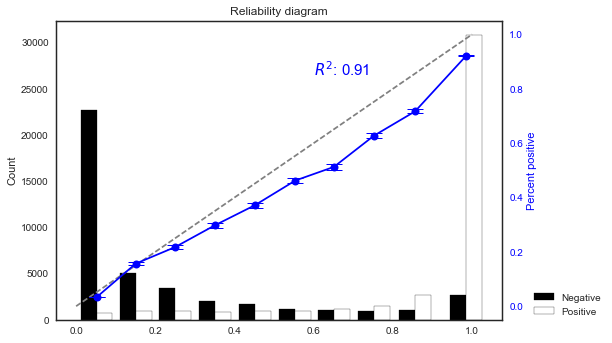

In [37]:
create_reliability_diagram(binary_probabilities, np.array([np.logical_not(binary_Y),binary_Y]).T,['Fail', 'Somatic'], 'blue')

## Feature importance analysis

In [38]:
feature_metrics = determine_feature_importance(baseline_binary_model(), X, np.array([np.logical_not(binary_Y),binary_Y]).T)

Epoch 1/10
41654/41654 [==============================] - 33s - loss: 0.4084 - acc: 0.8227    
Epoch 2/10
41654/41654 [==============================] - 33s - loss: 0.3511 - acc: 0.8532    
Epoch 3/10
41654/41654 [==============================] - 35s - loss: 0.3339 - acc: 0.8613    
Epoch 4/10
41654/41654 [==============================] - ETA: 0s - loss: 0.3261 - acc: 0.864 - 36s - loss: 0.3263 - acc: 0.8649    
Epoch 5/10
41654/41654 [==============================] - 36s - loss: 0.3193 - acc: 0.8674    
Epoch 6/10
41654/41654 [==============================] - 36s - loss: 0.3147 - acc: 0.8681    
Epoch 7/10
41654/41654 [==============================] - 34s - loss: 0.3109 - acc: 0.8704    
Epoch 8/10
41654/41654 [==============================] - 33s - loss: 0.3060 - acc: 0.8722    
Epoch 9/10
41654/41654 [==============================] - 33s - loss: 0.3035 - acc: 0.8732    
Epoch 10/10
41520/41654 [============================>.] - ETA: 0s

In [39]:
feature_metrics.head(15)

,feature,shuffled_loss,shuffled_accuracy,delta_loss,delta_accuracy
31,tumor_VAF,0.650099,0.756614,-0.344648,0.114947
0,disease,0.580268,0.757718,-0.274816,0.113843
1,reviewer,0.541300,0.787920,-0.235849,0.083641
48,tumor_var_avg_clipped_length,0.421468,0.814952,-0.116017,0.056609
51,tumor_var_avg_mapping_quality,0.446473,0.817160,-0.141022,0.054401
47,tumor_var_avg_basequality,0.371773,0.837639,-0.066321,0.033922
49,tumor_var_avg_distance_to_effective_3p_end,0.359545,0.852211,-0.054093,0.019350
55,tumor_var_avg_sum_mismatch_qualities,0.347787,0.852307,-0.042335,0.019254
2,normal_VAF,0.348813,0.859533,-0.043362,0.012028
39,tumor_ref_avg_num_mismaches_as_fraction,0.320667,0.865007,-0.015215,0.006554


## Elu activation function

In [40]:
# define baseline model
def baseline_binary_model():
    # create model
    model = Sequential()
    model.add(Dense(67, input_dim=71, kernel_initializer='normal', activation='elu'))
    model.add(Dense(23, activation='elu'))
    model.add(Dense(23, activation='elu'))
    model.add(Dense(2, kernel_initializer='normal', activation='sigmoid'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [41]:
binary_estimator = KerasClassifier(build_fn=baseline_binary_model, epochs=10, batch_size=5, verbose=1)

In [42]:
binary_kfold = KFold(n_splits=10, shuffle=True, random_state=seed)

In [43]:
if not os.path.exists('../data/deep_learning/binary_elu_probs.npy'):
    binary_probabilities = cross_val_predict(binary_estimator, X, binary_Y, cv=binary_kfold, method='predict_proba')
    np.save('../data/deep_learning/binary_elu_probs.npy', binary_probabilities)
else:
    binary_probabilities = np.load('../data/deep_learning/binary_elu_probs.npy')

Epoch 1/10
37488/37488 [==============================] - 32s - loss: 0.4356 - acc: 0.8067    
Epoch 2/10
37488/37488 [==============================] - 34s - loss: 0.3765 - acc: 0.8384    
Epoch 3/10
37488/37488 [==============================] - 31s - loss: 0.3591 - acc: 0.8484    
Epoch 4/10
37488/37488 [==============================] - 32s - loss: 0.3486 - acc: 0.8527    
Epoch 5/10
37488/37488 [==============================] - 31s - loss: 0.3406 - acc: 0.8571    
Epoch 6/10
37488/37488 [==============================] - 32s - loss: 0.3344 - acc: 0.8582    
Epoch 7/10
37488/37488 [==============================] - 32s - loss: 0.3302 - acc: 0.8603    
Epoch 8/10
37488/37488 [==============================] - 30s - loss: 0.3258 - acc: 0.8619    
Epoch 9/10
37488/37488 [==============================] - 31s - loss: 0.3221 - acc: 0.8638    
Epoch 10/10
37488/37488 [==============================] - 30s - loss: 0.4394 - acc: 0.8069    
Epoch 2/10
37488/37488 [=========================

37489/37489 [==============================] - 28s - loss: 0.3733 - acc: 0.8407    
Epoch 3/10
37489/37489 [==============================] - 29s - loss: 0.3580 - acc: 0.8481    
Epoch 4/10
37489/37489 [==============================] - 28s - loss: 0.3482 - acc: 0.8514    
Epoch 5/10
37489/37489 [==============================] - 29s - loss: 0.3391 - acc: 0.8577    
Epoch 6/10
37489/37489 [==============================] - 29s - loss: 0.3322 - acc: 0.8600    
Epoch 7/10
37489/37489 [==============================] - 32s - loss: 0.3258 - acc: 0.8624    
Epoch 8/10
37489/37489 [==============================] - 34s - loss: 0.3217 - acc: 0.8642    
Epoch 9/10
37489/37489 [==============================] - 30s - loss: 0.3173 - acc: 0.8655    
Epoch 10/10
37489/37489 [==============================] - 30s - loss: 0.4305 - acc: 0.8082    
Epoch 2/10
37489/37489 [==============================] - 30s - loss: 0.3695 - acc: 0.8421    
Epoch 3/10
37489/37489 [==============================] - 29

In [44]:
predicted = np.array([list(a).index(max(list(a))) for a in list(binary_probabilities)])

In [45]:
metrics.accuracy_score(binary_Y, predicted)

0.86419071397704905

In [46]:
print(metrics.classification_report(binary_Y, predicted))

             precision    recall  f1-score   support

          0       0.86      0.86      0.86     20498
          1       0.87      0.86      0.87     21156

avg / total       0.86      0.86      0.86     41654



In [47]:
somatic_prob = binary_probabilities[:,1]

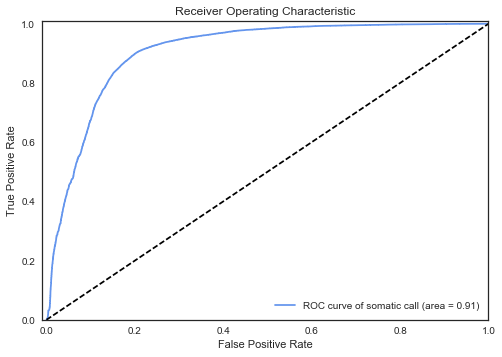

In [48]:
plt.title('Receiver Operating Characteristic')
fpr, tpr, _ = metrics.roc_curve(binary_Y, somatic_prob)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color='cornflowerblue',label='ROC curve of somatic call'
         ' (area = {0:0.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

confidence intervals +-:  [ 0.00128496  0.00446677  0.00683209  0.00932325  0.0088213   0.00740925
  0.00592803  0.00563814  0.00452751  0.00197963]


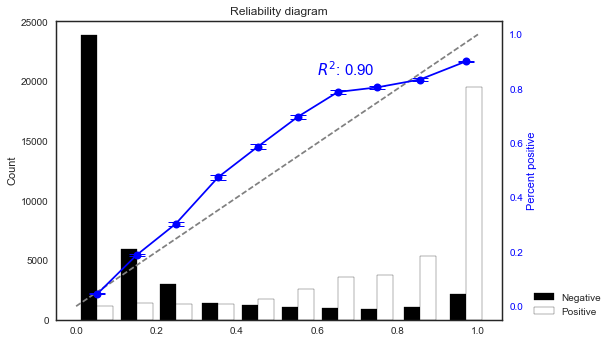

In [49]:

create_reliability_diagram(binary_probabilities, np.array([np.logical_not(binary_Y),binary_Y]).T,['Fail', 'Somatic'], 'blue')

## Feature importance analysis

In [50]:
feature_metrics = determine_feature_importance(baseline_binary_model(), X, np.array([np.logical_not(binary_Y),binary_Y]).T)

Epoch 1/10
41654/41654 [==============================] - 37s - loss: 0.4304 - acc: 0.8101    
Epoch 2/10
41654/41654 [==============================] - 38s - loss: 0.3686 - acc: 0.8441    
Epoch 3/10
41654/41654 [==============================] - 40s - loss: 0.3552 - acc: 0.8503    
Epoch 4/10
41654/41654 [==============================] - 39s - loss: 0.3432 - acc: 0.8553    
Epoch 5/10
41654/41654 [==============================] - 34s - loss: 0.3351 - acc: 0.8579    
Epoch 6/10
41654/41654 [==============================] - 42s - loss: 0.3276 - acc: 0.8625    
Epoch 7/10
41654/41654 [==============================] - 40s - loss: 0.3218 - acc: 0.8643    
Epoch 8/10
41654/41654 [==============================] - 42s - loss: 0.3184 - acc: 0.8657    
Epoch 9/10
41654/41654 [==============================] - 42s - loss: 0.3142 - acc: 0.8664    
Epoch 10/10
41650/41654 [============================>.] - ETA: 0s

In [51]:
feature_metrics.head(15)

,feature,shuffled_loss,shuffled_accuracy,delta_loss,delta_accuracy
0,disease,0.580244,0.750204,-0.274385,0.117780
31,tumor_VAF,0.626417,0.752293,-0.320557,0.115691
1,reviewer,0.553894,0.791185,-0.248034,0.076799
47,tumor_var_avg_basequality,0.427446,0.811087,-0.121586,0.056897
51,tumor_var_avg_mapping_quality,0.457023,0.813439,-0.151164,0.054545
48,tumor_var_avg_clipped_length,0.389558,0.828780,-0.083698,0.039204
55,tumor_var_avg_sum_mismatch_qualities,0.349348,0.850915,-0.043488,0.017069
2,normal_VAF,0.351961,0.853579,-0.046101,0.014404
49,tumor_var_avg_distance_to_effective_3p_end,0.340665,0.855452,-0.034806,0.012532
54,tumor_var_avg_se_mapping_quality,0.333058,0.857685,-0.027198,0.010299


# Somatic, ambigous, fail classifier

In [52]:
three_class = training_data.replace('g','f')

In [53]:
three_class.groupby('call').size()

call
a    14589
f     5909
s    21156
dtype: int64

In [54]:
# Get Labels
Y = pd.get_dummies(three_class.call).astype(float).values
# Get training data as numpy array
X = training_data.drop(['call', 'binary_call'], axis=1).astype(float).values

In [55]:
X.shape

(41654, 71)

In [56]:
Y.shape

(41654, 3)

In [57]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [58]:
# define baseline model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(67, input_dim=71, kernel_initializer='normal', activation='relu'))
    model.add(Dense(23, activation='relu'))
    model.add(Dense(23, activation='relu'))
    model.add(Dense(3, kernel_initializer='normal', activation='sigmoid'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [59]:
estimator = KerasClassifier(build_fn=baseline_model, epochs=10, batch_size=5, verbose=1)

In [60]:
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)

In [61]:
if not os.path.exists('../data/deep_learning/threeclass_relu_probs.npy'):
    probabilities = cross_val_predict(estimator, X, Y, cv=kfold, method='predict_proba')
    np.save('../data/deep_learning/threeclass_relu_probs.npy', probabilities)
else:
    probabilities = np.load('../data/deep_learning/threeclass_relu_probs.npy')

In [62]:
predicted = np.array([list(a).index(max(list(a))) for a in list(probabilities)])

In [63]:
label_binarizer = preprocessing.LabelBinarizer()

label_binarizer.fit(range(max(predicted)+1))
predicted_transformed = label_binarizer.transform(predicted)

In [64]:
metrics.accuracy_score(Y, predicted_transformed)

0.81591203725932682

#### Classification report
* 0 = ambiguous
* 1 = fail
* 2 = germline
* 3 = somatic

In [65]:
print(metrics.classification_report(Y, predicted_transformed))

             precision    recall  f1-score   support

          0       0.81      0.73      0.77     14589
          1       0.70      0.75      0.73      5909
          2       0.85      0.89      0.87     21156

avg / total       0.82      0.82      0.81     41654



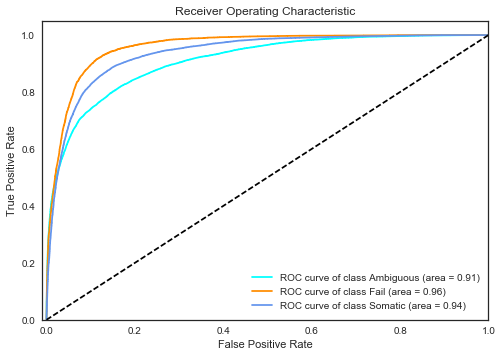

In [66]:
n_classes = Y.shape[1]
class_lookup = {0: 'Ambiguous', 1: 'Fail', 2: 'Somatic'}
fpr = dict()
tpr = dict()
roc_auc = dict()
plt.title('Receiver Operating Characteristic')
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'deeppink'])
for i, color in zip(range(n_classes), colors):
    fpr[i], tpr[i], _ = metrics.roc_curve(Y[:, i], probabilities[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], color=color, label='ROC curve of class {0}'
             ' (area = {1:0.2f})'.format(class_lookup[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

confidence intervals +-:  [ 0.00059922  0.00355891  0.00484212  0.00619793  0.00780359  0.00789745
  0.0084122   0.00745796  0.00514406  0.001602  ]


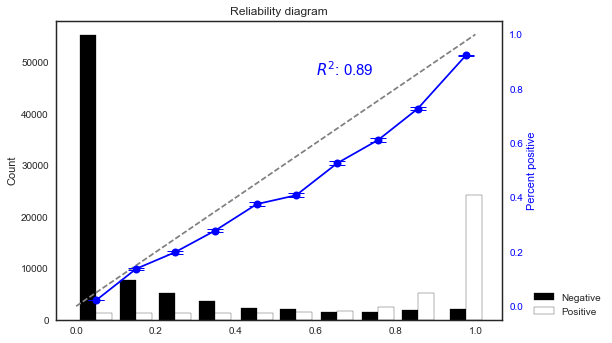

In [67]:
create_reliability_diagram(probabilities, Y,['Ambiguous','Fail','Somatic'], 'blue')

## Feature importance analysis

In [68]:
feature_metrics = determine_feature_importance(baseline_model(), X, Y)

Epoch 1/10
41654/41654 [==============================] - 37s - loss: 0.5895 - acc: 0.7527    
Epoch 2/10
41654/41654 [==============================] - 37s - loss: 0.5035 - acc: 0.7987    
Epoch 3/10
41654/41654 [==============================] - 36s - loss: 0.4810 - acc: 0.8061    
Epoch 4/10
41654/41654 [==============================] - 37s - loss: 0.4678 - acc: 0.8109    
Epoch 5/10
41654/41654 [==============================] - 39s - loss: 0.4577 - acc: 0.8135    
Epoch 6/10
41654/41654 [==============================] - 40s - loss: 0.4519 - acc: 0.8161    
Epoch 7/10
41654/41654 [==============================] - 42s - loss: 0.4449 - acc: 0.8172    
Epoch 8/10
41654/41654 [==============================] - 42s - loss: 0.4403 - acc: 0.8195    
Epoch 9/10
41654/41654 [==============================] - 42s - loss: 0.4344 - acc: 0.8231    
Epoch 10/10
41590/41654 [============================>.] - ETA: 0s

In [69]:
feature_metrics.head(15)

,feature,shuffled_loss,shuffled_accuracy,delta_loss,delta_accuracy
0,disease,0.862847,0.648389,-0.428063,0.169371
1,reviewer,0.726908,0.700437,-0.292124,0.117324
31,tumor_VAF,0.673087,0.725333,-0.238303,0.092428
51,tumor_var_avg_mapping_quality,0.611262,0.749004,-0.176477,0.068757
47,tumor_var_avg_basequality,0.542287,0.777428,-0.107502,0.040332
48,tumor_var_avg_clipped_length,0.500424,0.781390,-0.065639,0.036371
54,tumor_var_avg_se_mapping_quality,0.509927,0.783790,-0.075143,0.033970
49,tumor_var_avg_distance_to_effective_3p_end,0.486801,0.791617,-0.052016,0.026144
55,tumor_var_avg_sum_mismatch_qualities,0.498446,0.796802,-0.063662,0.020958
2,normal_VAF,0.485526,0.802156,-0.050742,0.015605


# Somatic fail classifier
remove ambiguous calls

In [70]:
two_class = three_class[three_class.call != 'a']

In [71]:
two_class.replace({'call': {'f': False, 's': True}}, inplace=True)

/Users/bainscou/anaconda/envs/manual_review/lib/python3.6/site-packages/pandas/core/generic.py:3485: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  regex=regex)


In [72]:
two_class.groupby('call').size()

call
False     5909
True     21156
dtype: int64

In [73]:
# Get Labels
binary_Y = two_class.call.astype(int).values
# Get training data as numpy array
X = two_class.drop(['call', 'binary_call'], axis=1).astype(float).values

In [74]:
X.shape

(27065, 71)

In [75]:
binary_Y.shape

(27065,)

In [76]:
# define baseline model
def baseline_binary_model():
    # create model
    model = Sequential()
    model.add(Dense(67, input_dim=71, kernel_initializer='normal', activation='relu'))
    model.add(Dense(23, activation='relu'))
    model.add(Dense(23, activation='relu'))
    model.add(Dense(2, kernel_initializer='normal', activation='sigmoid'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [77]:
binary_estimator = KerasClassifier(build_fn=baseline_binary_model, epochs=10, batch_size=5, verbose=1)

In [78]:
binary_kfold = KFold(n_splits=10, shuffle=True, random_state=seed)

In [79]:
if not os.path.exists('../data/deep_learning/no_amb_relu_probs.npy'):
    binary_probabilities = cross_val_predict(binary_estimator, X, binary_Y, cv=binary_kfold, method='predict_proba')
    np.save('../data/deep_learning/no_amb_relu_probs.npy', binary_probabilities)
else:
    binary_probabilities = np.load('../data/deep_learning/no_amb_relu_probs.npy')

In [80]:
predicted = np.array([list(a).index(max(list(a))) for a in list(binary_probabilities)])

In [81]:
metrics.accuracy_score(binary_Y, predicted)

0.94040273415850728

In [82]:
print(metrics.classification_report(binary_Y, predicted))

             precision    recall  f1-score   support

          0       0.88      0.85      0.86      5909
          1       0.96      0.97      0.96     21156

avg / total       0.94      0.94      0.94     27065



In [83]:
somatic_prob = binary_probabilities[:,1]

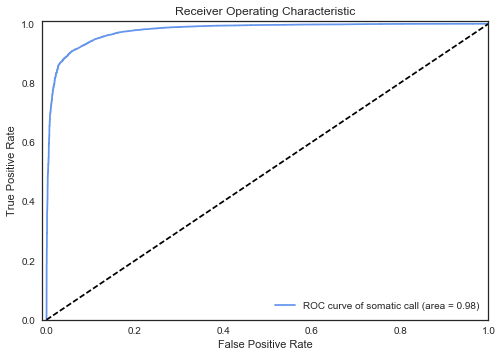

In [84]:
plt.title('Receiver Operating Characteristic')
fpr, tpr, _ = metrics.roc_curve(binary_Y, somatic_prob)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color='cornflowerblue',label='ROC curve of somatic call'
         ' (area = {0:0.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

confidence intervals +-:  [ 0.00076448  0.00744795  0.01226755  0.01465366  0.01620529  0.01764818
  0.01660018  0.0130748   0.01013683  0.00086672]


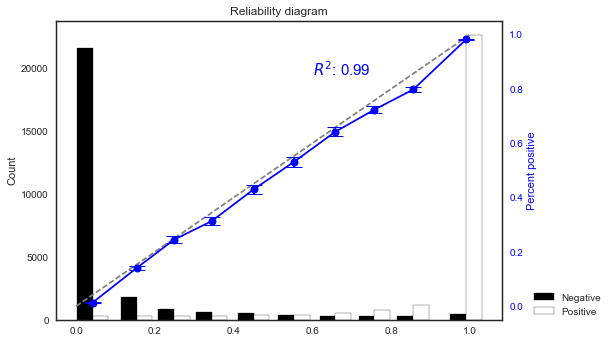

In [85]:
create_reliability_diagram(binary_probabilities, np.array([np.logical_not(binary_Y),binary_Y]).T,['Fail', 'Somatic'], 'blue')

## Feature importance analysis

In [86]:
feature_metrics = determine_feature_importance(baseline_binary_model(), X, pd.concat([~two_class.call,two_class.call],axis=1).astype(int).values)

Epoch 1/10
27065/27065 [==============================] - 26s - loss: 0.2254 - acc: 0.9050    
Epoch 2/10
27065/27065 [==============================] - 29s - loss: 0.1769 - acc: 0.9288    
Epoch 3/10
27065/27065 [==============================] - 26s - loss: 0.1655 - acc: 0.9332    
Epoch 4/10
27065/27065 [==============================] - 27s - loss: 0.1589 - acc: 0.9372    
Epoch 5/10
27065/27065 [==============================] - 27s - loss: 0.1551 - acc: 0.9379    
Epoch 6/10
27065/27065 [==============================] - 28s - loss: 0.1509 - acc: 0.9391    
Epoch 7/10
27065/27065 [==============================] - 28s - loss: 0.1478 - acc: 0.9412    
Epoch 8/10
27065/27065 [==============================] - 28s - loss: 0.1470 - acc: 0.9404    
Epoch 9/10
27065/27065 [==============================] - 28s - loss: 0.1440 - acc: 0.9413    
Epoch 10/10
27040/27065 [============================>.] - ETA: 0s

In [87]:
feature_metrics.head(15)

,feature,shuffled_loss,shuffled_accuracy,delta_loss,delta_accuracy
0,disease,0.497287,0.846998,-0.363719,0.100647
51,tumor_var_avg_mapping_quality,0.302189,0.883724,-0.168621,0.063920
1,reviewer,0.244677,0.897247,-0.111109,0.050397
47,tumor_var_avg_basequality,0.280788,0.901644,-0.147221,0.046000
2,normal_VAF,0.198583,0.928616,-0.065016,0.019028
12,normal_ref_avg_se_mapping_quality,0.148860,0.936228,-0.015293,0.011417
31,tumor_VAF,0.175993,0.936265,-0.042426,0.011380
39,tumor_ref_avg_num_mismaches_as_fraction,0.152059,0.938777,-0.018492,0.008868
34,tumor_ref_avg_basequality,0.137716,0.939257,-0.004149,0.008387
55,tumor_var_avg_sum_mismatch_qualities,0.152253,0.939479,-0.018686,0.008166


* elu model
* drop amb
* som/amb/fail model
* different roc curves for each class
* look at signal for miscalls
* ambig analysis
* run on filtered variants one study
* variant callers roc curve
* trained model feature analyasis top ten feature
* new model -- reviewer variability - shuffel all reviewers and classify model